In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
from scipy.stats import weibull_min
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance
import seaborn as sns
from reliability.Fitters import Fit_Weibull_2P

%matplotlib inline

In [2]:
#CSVfilelocation
#swh_sa is the list of Saral-Altika wind speed and Hs data
df=pd.read_csv("swh_sa.csv", sep='\t')
df.head()

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96


In [3]:
#Satellite wind speed data within 0.5 dd of 44017
colocated7= df[((df[['lon','lat']] - [287.951,40.693])**2).sum(axis=1) < 0.5**2]
yy=colocated7['swh']
xx=colocated7['wind_speed_alt']

In [4]:
data = colocated7["wind_speed_alt"]

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.17)

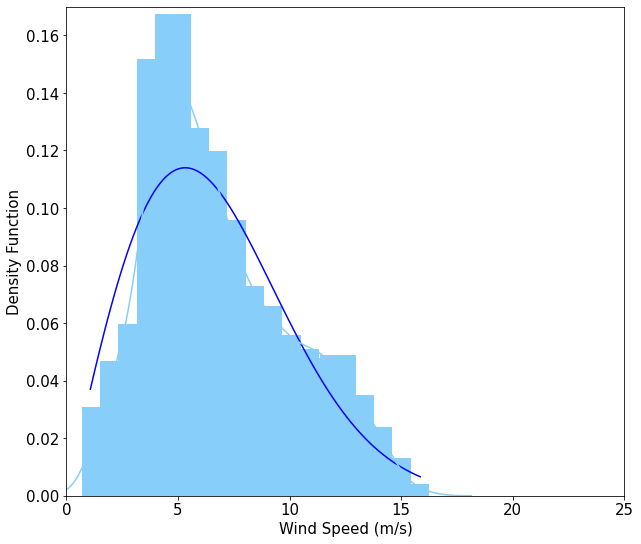

In [5]:

fig,ax=plt.subplots(figsize=(10,9))
shape, loc, scale = weibull_min.fit(data, floc=0,fc=2) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")
sns.distplot(xx,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 1.6)

plt.xlabel('Wind Speed (m/s)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0,25)
plt.ylim(0,0.17)

In [6]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [7]:
A

7.5247

In [8]:
k

2

In [9]:
mean_energy_density 

346.9044431672707

In [10]:
#Corresponding buoy wind speed data at 0.5 decimal degrees radius
df2=pd.read_csv('44017_df_50.csv')
x1=df2['Buoy 44017 U10']
y1=df2['Buoy 44017 Wave Height']
df2

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed
0,5/17/2015,1.13,1.806534,1.259667,3.733333
1,5/25/2015,0.78,9.133031,1.025750,7.730000
2,6/29/2015,1.58,7.527223,1.620857,6.157143
3,7/26/2015,0.62,4.717060,0.651600,4.506000
4,8/3/2015,1.39,8.731579,1.241600,6.810000
...,...,...,...,...,...
129,6/5/2019,1.51,8.932305,1.408889,8.713333
130,7/7/2019,0.92,5.118512,0.879571,4.647143
131,7/23/2019,1.72,4.215245,1.322000,3.600000
132,7/31/2019,0.85,4.516334,0.833429,4.041428


In [11]:
df2['Date'] = pd.to_datetime(df2["Buoy 44017 Time"])
df2['month'] = df2['Date'].dt.month_name()
df2['day'] = df2['Date'].dt.day_name()
df2.describe()

,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed
count,134.000000,134.000000,134.000000,134.000000
mean,1.227307,6.585159,1.237449,6.307609
std,0.610749,3.094114,0.537986,2.918809
min,0.480000,0.602178,0.506333,1.632000
25%,0.782500,4.415971,0.836821,4.201916
50%,1.085000,6.021778,1.137634,5.627500
75%,1.507500,8.430490,1.492917,7.820000
max,3.780000,15.756987,3.740539,13.923333


C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.17)

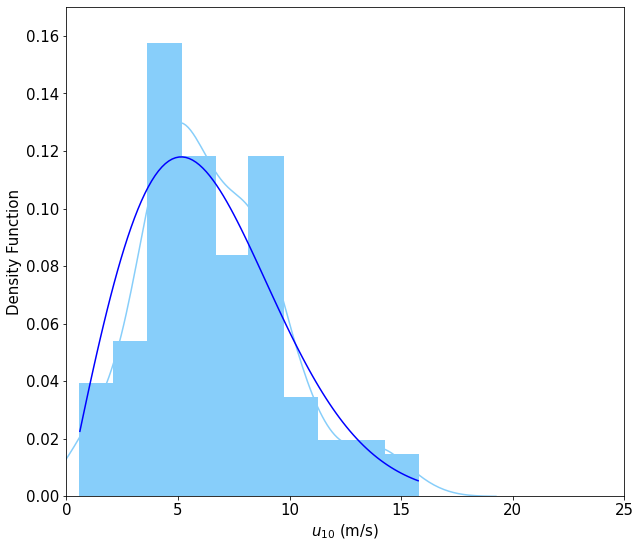

In [12]:
data = df2["Buoy 44017 U10"]
fig,ax=plt.subplots(figsize=(10,9))
sns.distplot(x1,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))

shape, loc, scale = weibull_min.fit(data, floc=0,fc=2) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 1.6)
plt.xlabel('$u_{10}$ (m/s)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0,25)
plt.ylim(0,0.17)

In [13]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [14]:
A

7.2709

In [15]:
k

2

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.89)

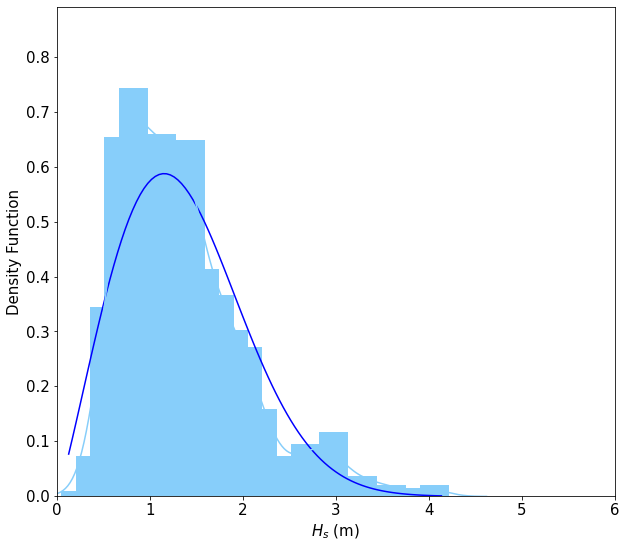

In [16]:
#satellite wave height 0.5 dd around buoy 55017
data = colocated7['swh']
fig,ax=plt.subplots(figsize=(10,9))
shape, loc, scale = weibull_min.fit(data, floc=0) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")
sns.distplot(yy,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 0.31)

plt.xlabel('$H_s$ (m)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0,6)
plt.ylim(0,0.89)

In [17]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [18]:
A

1.5386

In [19]:
k

2.158

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


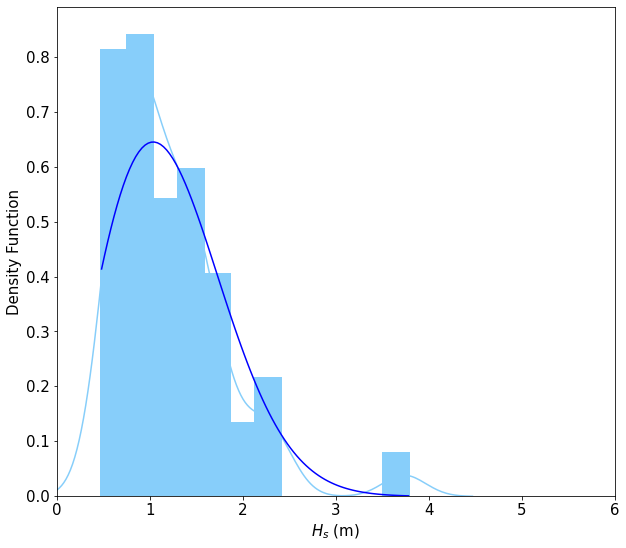

In [20]:
#corresponding buoy wave height
data = df2['Buoy 44017 Wave Height']
fig,ax=plt.subplots(figsize=(10,9))
sns.distplot(y1,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))

shape, loc, scale = weibull_min.fit(data, floc=0) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 0.3)

plt.xlabel('$H_s$ (m)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.xlim(0,6)
plt.ylim(0,0.89)
plt.tick_params(axis='both', which='major', labelsize=15)

In [21]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [22]:
A

1.391

In [23]:
k

2.1354

In [24]:
#directory to buoy 44017 files
df1=pd.read_csv('b44017_wind_wave.csv', sep='\t')
x2=df1['u10']
y2=df1['WVHT']

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


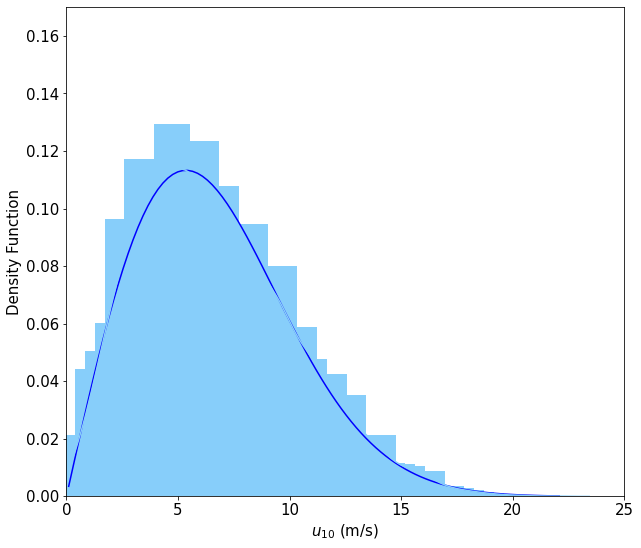

In [25]:
data = df1['u10']
fig,ax=plt.subplots(figsize=(10,9))
#plt.hist(data, density=True, alpha=0.5)
shape, loc, scale = weibull_min.fit(data, floc=0,fc=2) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")

sns.distplot(x2,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 1.6)


plt.xlabel('$u_{10}$ (m/s)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.xlim(0,25)
plt.ylim(0,0.17)
plt.tick_params(axis='both', which='major', labelsize=15)

In [26]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [27]:
A

7.5704

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


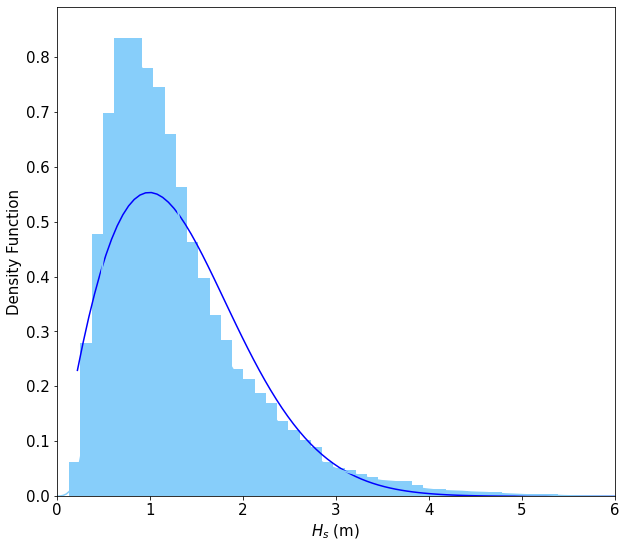

In [28]:
data = df1['WVHT']
fig,ax=plt.subplots(figsize=(10,9))
shape, loc, scale = weibull_min.fit(data, floc=0) # if you want to fix shape as 2: set fc=2
x = np.linspace(data.min(), data.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x),color="blue",label="Buoy44097-0.25 decimal degrees Saral/ALtika"+"(Scale:"+str(round(scale,2))+";Shape:"+str(round(shape,2))+")")

sns.distplot(y2,hist_kws=dict(alpha=1),color='lightskyblue',kde_kws=dict(alpha=0))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 0.3)

plt.xlabel('$H_s$ (m)', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.xlim(0,6)
plt.ylim(0,0.89)
plt.tick_params(axis='both', which='major', labelsize=15)

In [29]:
# parameters
A = round(scale,4) # from weibull
k = round(shape,4) 
air_density = 1.225 # kg/m^3

from scipy.special import gamma, factorial
mean_energy_density = 0.5*air_density*A**3*gamma(1+3/k)

In [30]:
A

1.4902

In [31]:
k

1.8756